In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [6]:
folder = 'brain_tumor_dataset/yes/'    # all images having yes
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are rename in the yes dir")

All files are rename in the yes dir


In [7]:
folder = 'brain_tumor_dataset/no/'    # all images having yes
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are rename in the no dir")

All files are rename in the no dir


# EDA

In [8]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listyes = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listyes)
print(number_files_no)

155
98


Text(0.5, 1.0, 'Count of Brain Tumor Images')

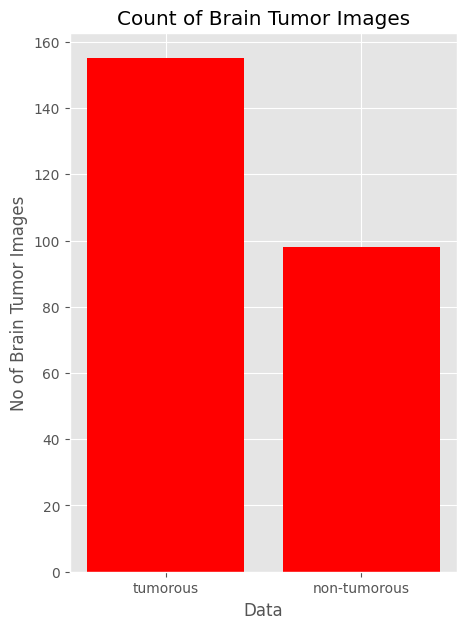

In [9]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")

# Data Augmentation
# 155(61%), 98(39%)
# imbalance

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [11]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [12]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [15]:
import time
start_time = time.time()

yes_path = 'brain_tumor_dataset/yes' 
no_path = 'brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:9:58.35596013069153


In [16]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/" 
    no_path = "augmented_data/no/"
    
    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    
    n = (n_pos + n_neg)
    
    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n
    
    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [17]:
data_summary(augmented_data_path)

Number of sample: 2064
1084 Number of positive sample in percentage: 52.51937984496124%
980 Number of negative sample in percentage: 47.48062015503876%


In [18]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1084
980


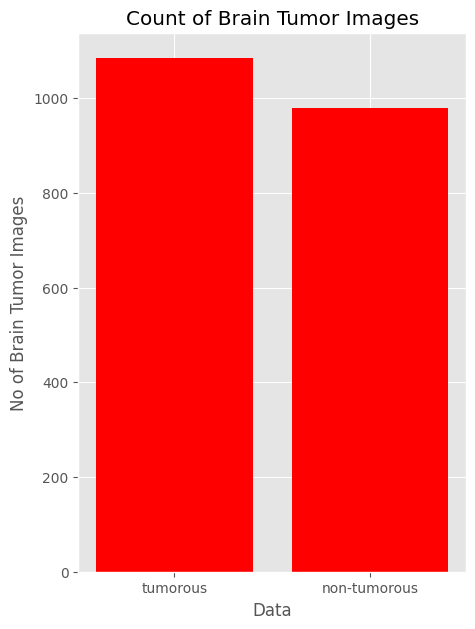

In [19]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# Data Preprocessing

In [ ]:
# Convert BGR TO GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [20]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)
    
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

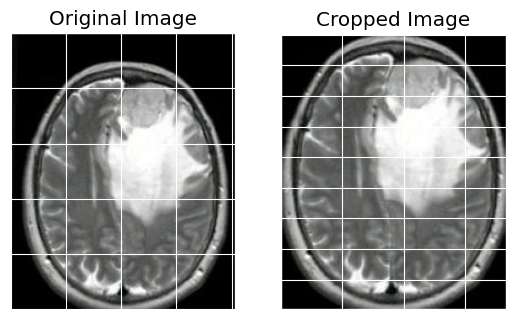

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [23]:
img = cv2.imread('augmented_data/yes/aug_Y_100_0_1882.jpg')
crop_brain_tumor(img, True)

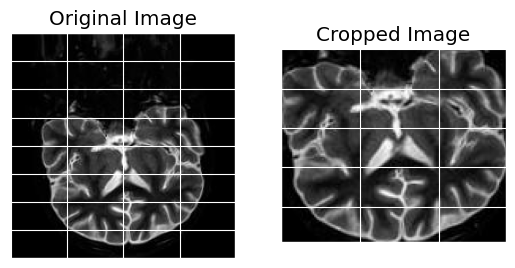

array([[[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        ...,
        [4, 4, 4],
        [5, 5, 5],
        [5, 5, 5]],

       [[1, 1, 1],
        [1, 1, 1],
        [2, 2, 2],
        ...,
        [4, 4, 4],
        [5, 5, 5],
        [6, 6, 6]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [3, 3, 3],
        [5, 5, 5],
        [6, 6, 6]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [24]:
img = cv2.imread('augmented_data/no/aug_N_10_0_1875.jpg')
crop_brain_tumor(img, True)

In [25]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [ ]:
# image loading

In [26]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]
    
    image_width, image_height=image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)
    
    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [27]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 2064
X SHAPE is : (2064, 240, 240, 3)
y SHAPE is : (2064,)


In [28]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

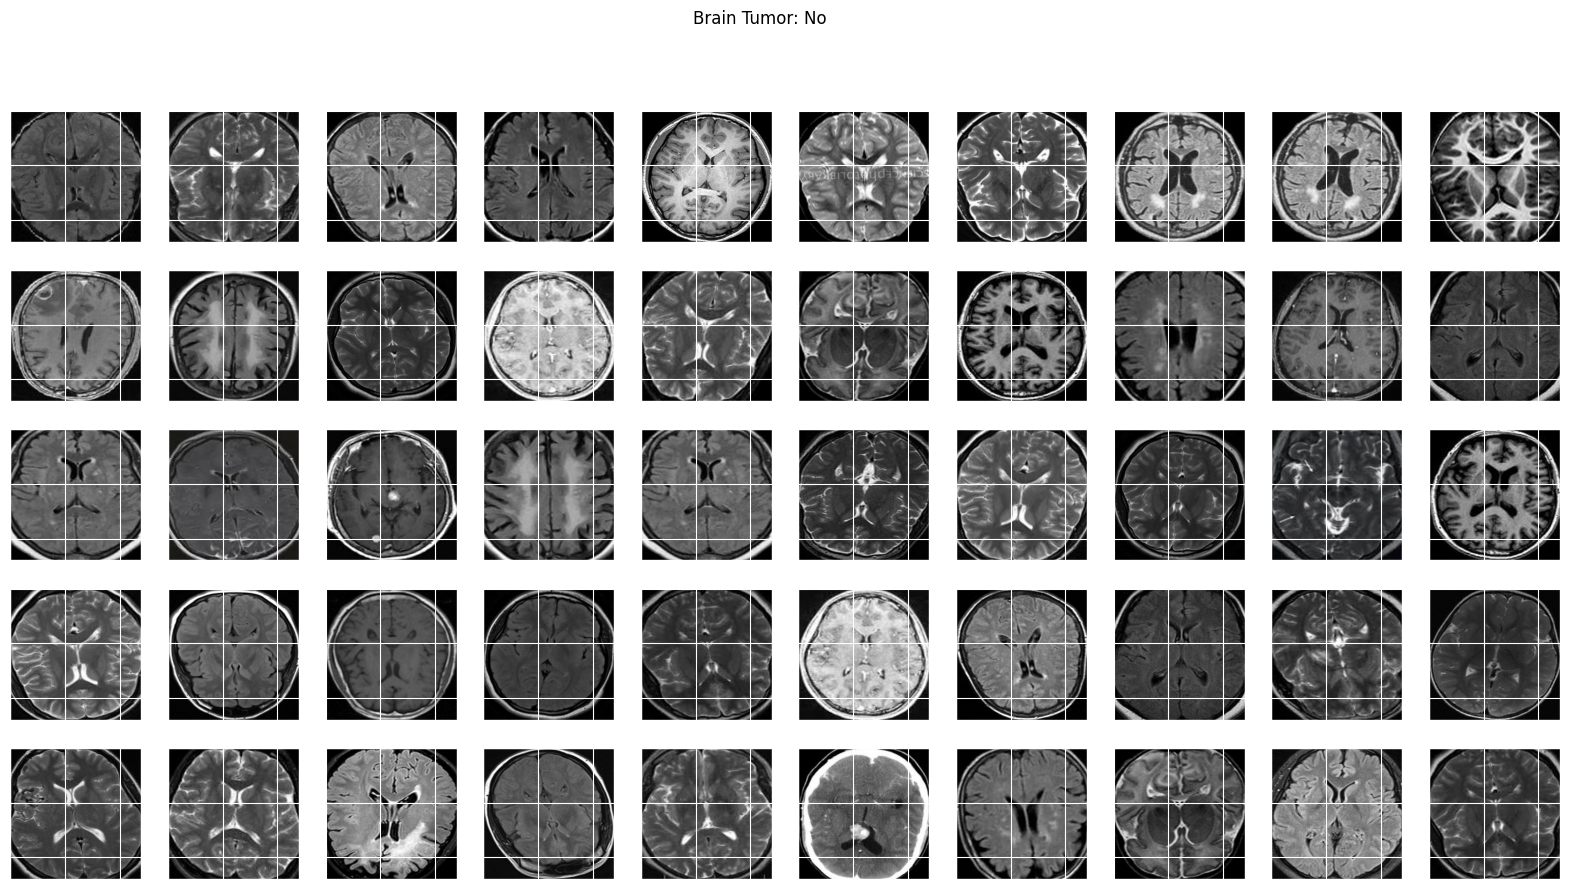

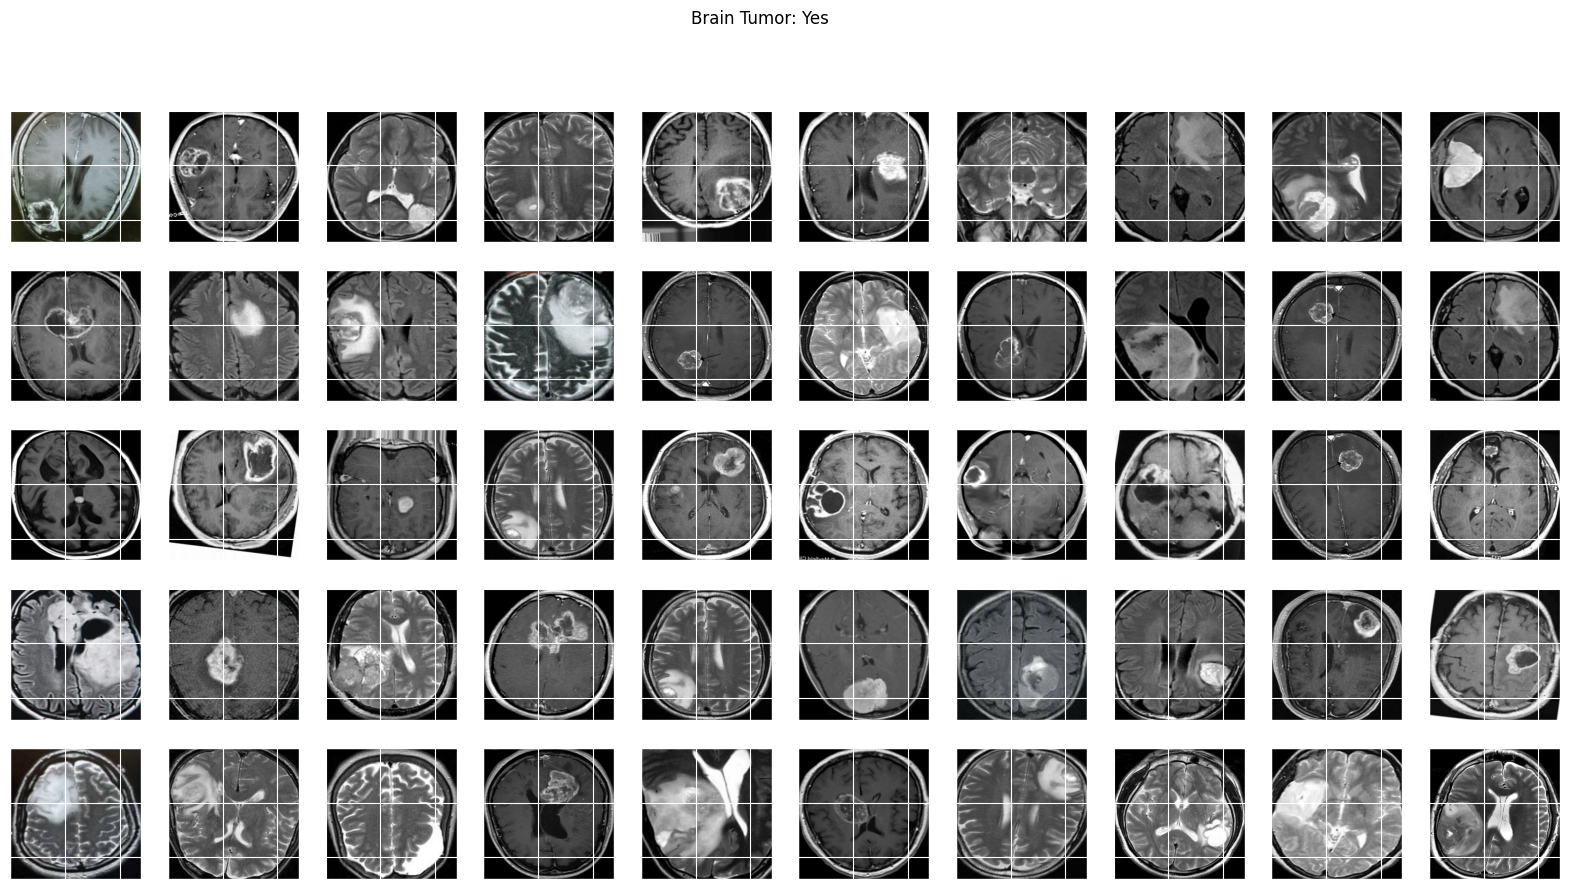

In [29]:
plot_sample_images(X,y)

In [ ]:
# Data spliting
# Train
# Test
# Validation

In [30]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [31]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [32]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [33]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [34]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [35]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [36]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [38]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(922,1084):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [39]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [40]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [41]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833,979):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

# Model Buliding

In [42]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [43]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 1445 images belonging to 2 classes.


In [44]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 310 images belonging to 2 classes.


In [45]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 308 images belonging to 2 classes.


In [46]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [47]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [48]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [49]:
# callback
filepath = 'model.h5'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [50]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True, clipnorm=1.0)
model_01.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [51]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 0.7629 - accuracy: 0.4369 
Epoch 1: val_loss improved from inf to 0.71005, saving model to model.h5


C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 410s 42s/step - loss: 0.7629 - accuracy: 0.4369 - val_loss: 0.7101 - val_accuracy: 0.4935 - lr: 1.0000e-04
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.7478 - accuracy: 0.4625 
Epoch 2: val_loss did not improve from 0.71005
10/10 [==============================] - 413s 43s/step - loss: 0.7478 - accuracy: 0.4625 - val_loss: 0.7111 - val_accuracy: 0.5162 - lr: 1.0000e-04


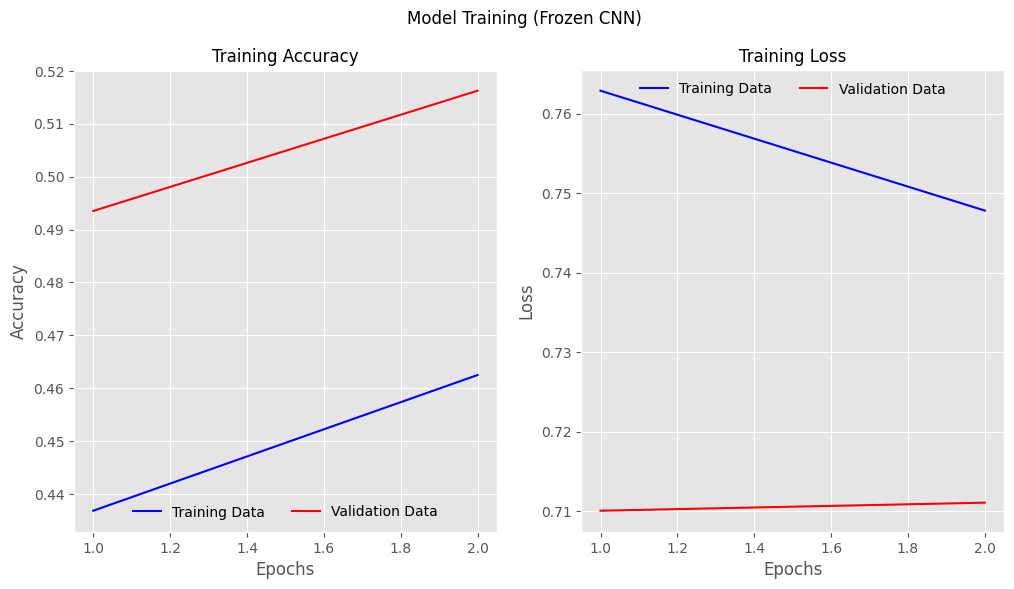

In [52]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [53]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/vgg19_model_01.h5", overwrite=True)

In [54]:
model_01.load_weights("model_weights/vgg19_model_01.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

10/10 [==============================] - 201s 19s/step - loss: 0.6973 - accuracy: 0.5419


In [55]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.7249501943588257
Validation Acc: 0.4577922224998474
Testing Loss: 0.6973045468330383
Testing Acc: 0.5419355034828186


In [56]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

310/310 [==============================] - 271s 801ms/step


In [ ]:
# Increamental unfreezing and fine tuning

In [57]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [58]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [59]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True, clipnorm=1.0)
model_02.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [60]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 0.7343 - accuracy: 0.5156 
Epoch 1: val_loss improved from 0.71005 to 0.70576, saving model to model.h5


C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 497s 51s/step - loss: 0.7343 - accuracy: 0.5156 - val_loss: 0.7058 - val_accuracy: 0.4870 - lr: 1.0000e-04
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.5094 
Epoch 2: val_loss improved from 0.70576 to 0.70083, saving model to model.h5
10/10 [==============================] - 493s 52s/step - loss: 0.7018 - accuracy: 0.5094 - val_loss: 0.7008 - val_accuracy: 0.5260 - lr: 1.0000e-04


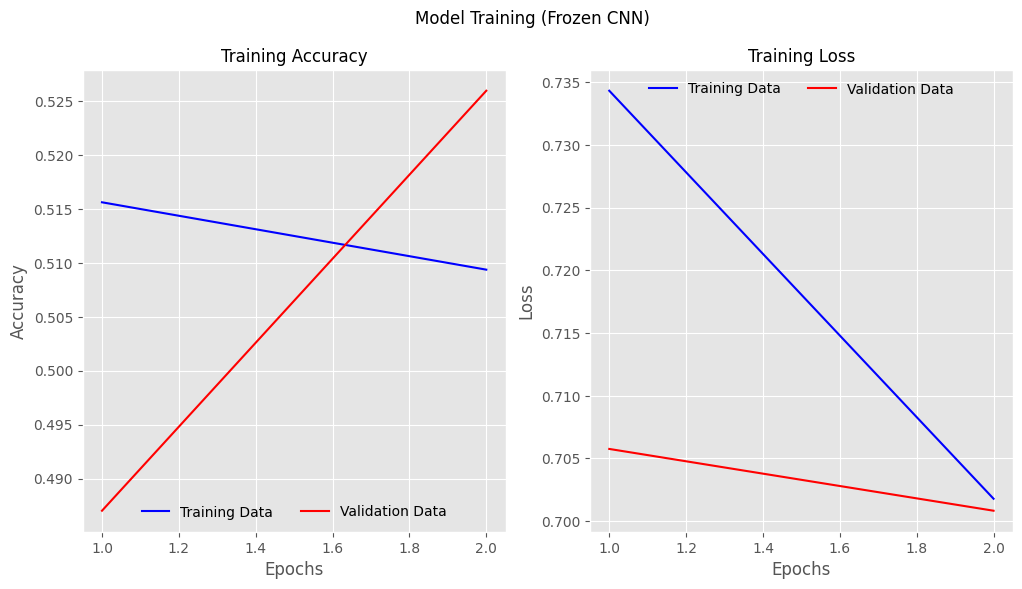

In [61]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [62]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg19_model_02.h5", overwrite=True)

In [63]:
model_02.load_weights("model_weights/vgg19_model_02.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

10/10 [==============================] - 248s 25s/step - loss: 0.6862 - accuracy: 0.5323


In [ ]:
# Unfreezing the entire network

In [65]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.h5')

from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True, clipnorm=1.0)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [67]:
model_03.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [69]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath="model_weights/vgg_unfrozen.h5", overwrite=True)

In [70]:
model_03.load_weights("model_weights/vgg_unfrozen.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

10/10 [==============================] - 197s 19s/step - loss: 0.6962 - accuracy: 0.5484
